<h1> Parameter Tuning
    
    Look for the best kernel initializer and bias initializer

# Importing libraries:

In [15]:
!pip install pandas
!pip install sklearn
!pip install matplotlib

import matplotlib.pyplot as plt
import pandas as pd;
import numpy as np;
import sklearn

# parameters
steps = 48
n_hidden = 2
units = 100
batch_size = 48
features_num = 14

# months to evaluate model on
date = 2018090000

# lists to append results
mae_gen = []
mae_nor = []
mae_spi = []
rmse_gen = []
rmse_nor = []
rmse_spi = []
y_pred_list = []
time_count = []

# Import data; set X and y; fill nan values and split in test and training  data:

In [16]:
# import data
data = pd.read_csv('Data_set_1_smaller_(1).csv', index_col = 0)

# data
data = data.loc[data.index > date, :]

# reset index
data.reset_index(inplace = True)
data.drop('index', axis = 1, inplace = True)

# fill nan values
data.fillna(data.mean(), inplace = True)

from sklearn.model_selection import train_test_split

# divide data into train and test 
data_train, data_test = train_test_split(
         data, test_size = 0.15, shuffle=False)

# Apply feature scaling:

In [17]:
from sklearn.preprocessing import MinMaxScaler

# data scaling  (including offer (y))
sc_X = MinMaxScaler()
data_train = sc_X.fit_transform(data_train)
data_test = sc_X.transform(data_test)

# Importing the Keras libraries and packages:

In [18]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras import initializers
from keras import optimizers

# Need to process data with spike occurences the same way as features and offers:
(Required to evaluate predictions in both normal regions and spike regions)

In [19]:
# download data for shaded area
data = pd.read_csv('Spike_binary_1std.csv', index_col = 0)

# set predictive window according with tuning best results
data = data.loc[data.index > date, :]

# make sure shaded area will correspond to values outputed by LSTM
data.reset_index(drop = True, inplace = True)

# fill_nan is already made - so lets split data into test and train
from sklearn.model_selection import train_test_split

# divide data into train and test 
shade_train, shade_test = train_test_split(
         data, test_size = 0.15, shuffle = False)

# reset index of testing data
shade_test.reset_index(drop = True, inplace = True)

# function to split data into correct shape for RNN
def split_data(shade_test, steps):
    y_spike_occ = list()
    upper_lim = list()
    lower_lim = list()
    for i in range(steps, len(shade_test.index)):
        y_spike_occ.append(shade_test['spike_occurance'][i])
        upper_lim.append(shade_test['spike_upperlim'][i])
        lower_lim.append(shade_test['spike_lowerlim'][i])
    return np.array(y_spike_occ), np.array(upper_lim), np.array(lower_lim)

# function to cut data set so it can be divisible by the batch_size
def cut_data(data, batch_size):
     # see if it is divisivel
    condition = data.shape[0] % batch_size
    if condition == 0:
        return data
    else:
        return data[: -condition]

# shape y_spike_occ for the right size to compare results in normal and spike regions
y_spike_occ, spike_upperlim, spike_lowerlim = split_data(shade_test, steps)
y_spike_occ = cut_data(y_spike_occ, batch_size)

# Create regressor:

In [20]:
from sklearn.model_selection import ParameterGrid

# Dictionary to include the parameters
parameters = {'bias_initializer':[initializers.Zeros(),
                                 initializers.Ones()],
              'kernel_initializer': ['glorot_uniform',
                                     'he_normal',
                                     'he_uniform']
               }

all_param = ParameterGrid(parameters)

# function to split data into correct shape for RNN
def split_data(X, y, steps):
    X_, y_ = list(), list()
    for i in range(steps, len(y)):
        X_.append(X[i - steps : i, :])
        y_.append(y[i]) 
    return np.array(X_), np.array(y_)

# function to cut data set so it can be divisible by the batch_size
def cut_data(data, batch_size):
     # see if it is divisivel
    condition = data.shape[0] % batch_size
    if condition == 0:
        return data
    else:
        return data[: -condition]

# divide features and labels
X_train = data_train[:, 0:14] 
y_train = data_train[:, -1]
X_test = data_test[:, 0:14] 
y_test = data_test[:, -1] 

# divide data into train and test 
X_train, X_val, y_train, y_val = train_test_split(
         X_train, y_train, test_size = 0.15, shuffle=False)

# put data into correct shape
X_train, y_train = split_data(X_train, y_train, steps)
X_test, y_test = split_data(X_test, y_test, steps)
X_val, y_val = split_data(X_val, y_val, steps)

X_train = cut_data(X_train, batch_size)
y_train = cut_data(y_train, batch_size)
X_test = cut_data(X_test, batch_size)
y_test = cut_data(y_test, batch_size)
X_val = cut_data(X_val, batch_size)
y_val = cut_data(y_val, batch_size)

# inverse of test set should not be inside the loop 
y_test = (y_test * sc_X.data_range_[14]) + (sc_X.data_min_[14])

# smal adjustment
y_test = pd.Series(y_test)
y_test.replace(0, 0.0001,inplace = True)

for i in range(len(all_param)):
    
    bias_initializer = all_param[i]['bias_initializer']
    kernel_initializer = all_param[i]['kernel_initializer']

    # design the LSTM
    def regressor_tunning(kernel_initializer = 'he_uniform',
                          bias_initializer = initializers.Ones()):
        model = Sequential()
        if n_hidden == 0:
            model.add(LSTM(units = units,                    
                           input_shape = (steps, features_num), 
                           kernel_initializer = kernel_initializer,
                           bias_initializer = bias_initializer))
            model.add(LeakyReLU(alpha = 0.2))
            model.add(Dropout(0.2))
        else:
            model.add(LSTM(units = units,                    
                           input_shape = (steps, features_num), 
                           return_sequences = True,
                           kernel_initializer = kernel_initializer,
                           bias_initializer = bias_initializer))
            model.add(LeakyReLU(alpha = 0.2))
            model.add(Dropout(0.2))
            model.add(LSTM(units = units, 
                           input_shape = (steps, features_num), 
                           kernel_initializer = kernel_initializer,
                           bias_initializer = bias_initializer))
            model.add(LeakyReLU(alpha = 0.2))
            model.add(Dropout(0.2))
        model.add(Dense(1, activation='linear'))
        optimizer = optimizers.RMSprop()
        model.compile(loss = 'mse', metrics = ['mse', 'mae'], optimizer = optimizer)
        return model

    model = regressor_tunning(bias_initializer, kernel_initializer)

    # fitting the LSTM to the training set
    history = model.fit(X_train,
                        y_train, 
                        batch_size = batch_size, 
                        epochs = 100,
                        shuffle = False, 
                        validation_data = (X_val, y_val))
    
    model.reset_states()
    
    # make new predicitons with test set
    y_pred = model.predict(X_test, batch_size = batch_size)
    
    # prices col = 15 (inverso should not be used as scalling was made with the whole data set)
    y_pred = (y_pred * sc_X.data_range_[14]) + (sc_X.data_min_[14])
    
    y_pred_list.append(y_pred)
    
    from sklearn.metrics import mean_squared_error as mse
    from sklearn.metrics import mean_absolute_error as mae

    rmse_error = mse(y_test, y_pred, squared = False)
    mae_error = mae(y_test, y_pred)
    
    rmse_gen.append(rmse_error)
    mae_gen.append(mae_error)
    
    # =============================================================================
    # Metrics evaluation on spike regions
    # =============================================================================
    
    # Need to process data with spike occurences the same way as features
    data = pd.read_csv('Spike_binary_1std.csv', index_col = 0)

    # set predictive window according with tuning best results
    data = data.loc[data.index > date, :]

    # make sure shaded area will correspond to values outputed by LSTM
    data.reset_index(drop = True, inplace = True)

    # fill_nan is already made - so lets split data into test and train
    from sklearn.model_selection import train_test_split

    # divide data into train and test 
    shade_train, shade_test = train_test_split(
             data, test_size = 0.15, shuffle = False)

    # reset index of testing data
    shade_test.reset_index(drop = True, inplace = True)

    # function to split data into correct shape for RNN
    def split_data_shade(shade_test, steps):
        y_spike_occ = list()
        upper_lim = list()
        lower_lim = list()
        for i in range(steps, len(shade_test.index)):
            y_spike_occ.append(shade_test['spike_occurance'][i])
            upper_lim.append(shade_test['spike_upperlim'][i])
            lower_lim.append(shade_test['spike_lowerlim'][i])
        return np.array(y_spike_occ), np.array(upper_lim), np.array(lower_lim)
    
    # function to cut data set so it can be divisible by the batch_size
    def cut_data_shade(data, batch_size):
         # see if it is divisivel
        condition = data.shape[0] % batch_size
        if condition == 0:
            return data
        else:
            return data[: -condition]
    
    # shape y_spike_occ for the right size to compare results in normal and spike regions
    y_spike_occ, spike_upperlim, spike_lowerlim = split_data_shade(shade_test, steps)
    y_spike_occ = cut_data_shade(y_spike_occ, batch_size)
        
    # continue
    
    # select y_pred and y_test only for regions with spikes
    y_test_spike = (y_test.T * y_spike_occ).T
    y_pred_spike = (y_pred.T * y_spike_occ).T
    y_test_spike = y_test_spike[y_test_spike != 0]
    y_pred_spike = y_pred_spike[y_pred_spike != 0]
    
    # calculate metric
    rmse_spike = mse(y_test_spike, y_pred_spike, squared = False)
    mae_spike = mae(y_test_spike, y_pred_spike)
    
    rmse_spi.append(rmse_spike)
    mae_spi.append(mae_spike)
    
    # =============================================================================
    # Metric evaluation on normal regions
    # =============================================================================
    
    # inverse y_spike_occ so the only normal occurences are chosen
    y_normal_occ = (y_spike_occ - 1) * (-1)
    
    # sanity check
    y_normal_occ.sum() + y_spike_occ.sum() # gives the correct total 
    
    # select y_pred and y_test only for normal regions
    y_test_normal = (y_test.T * y_normal_occ).T
    y_pred_normal = (y_pred.T * y_normal_occ).T
    y_test_normal = y_test_normal[y_test_normal != 0.00]
    y_pred_normal = y_pred_normal[y_pred_normal != 0.00]
    
    # calculate metric
    rmse_normal = mse(y_test_normal, y_pred_normal, squared = False)
    mae_normal = mae(y_test_normal, y_pred_normal)
    
    rmse_nor.append(rmse_normal)
    mae_nor.append(mae_normal)
    

Epoch 1/100
87/87 [==============================] - 12s 139ms/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0310 - val_loss: 5.6415e-04 - val_mse: 5.6415e-04 - val_mae: 0.0126
Epoch 2/100
87/87 [==============================] - 10s 118ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0224 - val_loss: 5.0598e-04 - val_mse: 5.0598e-04 - val_mae: 0.0116
Epoch 3/100
87/87 [==============================] - 10s 110ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0203 - val_loss: 4.0239e-04 - val_mse: 4.0239e-04 - val_mae: 0.0120
Epoch 4/100
87/87 [==============================] - 8s 93ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0191 - val_loss: 3.9946e-04 - val_mse: 3.9946e-04 - val_mae: 0.0122
Epoch 5/100
87/87 [==============================] - 8s 90ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0184 - val_loss: 4.0671e-04 - val_mse: 4.0671e-04 - val_mae: 0.0125
Epoch 6/100
87/87 [==============================] - 8s 91ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0181 - val_loss: 4.0339e-04 - 

87/87 [==============================] - 8s 95ms/step - loss: 7.8724e-04 - mse: 7.8724e-04 - mae: 0.0130 - val_loss: 3.0705e-04 - val_mse: 3.0705e-04 - val_mae: 0.0111
Epoch 46/100
87/87 [==============================] - 9s 98ms/step - loss: 8.0937e-04 - mse: 8.0937e-04 - mae: 0.0131 - val_loss: 2.8286e-04 - val_mse: 2.8286e-04 - val_mae: 0.0103
Epoch 47/100
87/87 [==============================] - 8s 94ms/step - loss: 8.1231e-04 - mse: 8.1231e-04 - mae: 0.0132 - val_loss: 2.5436e-04 - val_mse: 2.5436e-04 - val_mae: 0.0097
Epoch 48/100
87/87 [==============================] - 8s 96ms/step - loss: 8.1387e-04 - mse: 8.1387e-04 - mae: 0.0132 - val_loss: 2.8957e-04 - val_mse: 2.8957e-04 - val_mae: 0.0104
Epoch 49/100
87/87 [==============================] - 8s 95ms/step - loss: 7.9188e-04 - mse: 7.9188e-04 - mae: 0.0129 - val_loss: 3.0028e-04 - val_mse: 3.0028e-04 - val_mae: 0.0107
Epoch 50/100
87/87 [==============================] - 8s 95ms/step - loss: 8.0246e-04 - mse: 8.0246e-04 - ma

87/87 [==============================] - 8s 92ms/step - loss: 6.9970e-04 - mse: 6.9970e-04 - mae: 0.0121 - val_loss: 3.6862e-04 - val_mse: 3.6862e-04 - val_mae: 0.0121
Epoch 91/100
87/87 [==============================] - 8s 92ms/step - loss: 6.9271e-04 - mse: 6.9271e-04 - mae: 0.0120 - val_loss: 3.7993e-04 - val_mse: 3.7993e-04 - val_mae: 0.0118
Epoch 92/100
87/87 [==============================] - 8s 92ms/step - loss: 7.1011e-04 - mse: 7.1011e-04 - mae: 0.0121 - val_loss: 4.3992e-04 - val_mse: 4.3992e-04 - val_mae: 0.0138
Epoch 93/100
87/87 [==============================] - 8s 91ms/step - loss: 6.9597e-04 - mse: 6.9597e-04 - mae: 0.0123 - val_loss: 4.1083e-04 - val_mse: 4.1083e-04 - val_mae: 0.0118
Epoch 94/100
87/87 [==============================] - 8s 92ms/step - loss: 6.8899e-04 - mse: 6.8899e-04 - mae: 0.0121 - val_loss: 5.3930e-04 - val_mse: 5.3930e-04 - val_mae: 0.0141
Epoch 95/100
87/87 [==============================] - 8s 92ms/step - loss: 6.8044e-04 - mse: 6.8044e-04 - ma

87/87 [==============================] - 8s 97ms/step - loss: 8.0999e-04 - mse: 8.0999e-04 - mae: 0.0131 - val_loss: 2.8623e-04 - val_mse: 2.8623e-04 - val_mae: 0.0106
Epoch 36/100
87/87 [==============================] - 8s 96ms/step - loss: 8.2787e-04 - mse: 8.2787e-04 - mae: 0.0135 - val_loss: 2.9983e-04 - val_mse: 2.9983e-04 - val_mae: 0.0114
Epoch 37/100
87/87 [==============================] - 9s 100ms/step - loss: 8.4051e-04 - mse: 8.4051e-04 - mae: 0.0134 - val_loss: 2.8835e-04 - val_mse: 2.8835e-04 - val_mae: 0.0102
Epoch 38/100
87/87 [==============================] - 9s 99ms/step - loss: 8.0355e-04 - mse: 8.0355e-04 - mae: 0.0129 - val_loss: 2.8985e-04 - val_mse: 2.8985e-04 - val_mae: 0.0108
Epoch 39/100
87/87 [==============================] - 8s 96ms/step - loss: 8.3656e-04 - mse: 8.3656e-04 - mae: 0.0134 - val_loss: 2.6287e-04 - val_mse: 2.6287e-04 - val_mae: 0.0104
Epoch 40/100
87/87 [==============================] - 8s 96ms/step - loss: 8.0920e-04 - mse: 8.0920e-04 - m

87/87 [==============================] - 8s 96ms/step - loss: 7.0642e-04 - mse: 7.0642e-04 - mae: 0.0124 - val_loss: 6.0526e-04 - val_mse: 6.0526e-04 - val_mae: 0.0131
Epoch 80/100
87/87 [==============================] - 8s 97ms/step - loss: 6.8537e-04 - mse: 6.8537e-04 - mae: 0.0125 - val_loss: 4.0560e-04 - val_mse: 4.0560e-04 - val_mae: 0.0125
Epoch 81/100
87/87 [==============================] - 8s 97ms/step - loss: 7.0156e-04 - mse: 7.0156e-04 - mae: 0.0126 - val_loss: 3.7074e-04 - val_mse: 3.7074e-04 - val_mae: 0.0112
Epoch 82/100
87/87 [==============================] - 9s 100ms/step - loss: 7.5150e-04 - mse: 7.5150e-04 - mae: 0.0127 - val_loss: 9.4315e-04 - val_mse: 9.4315e-04 - val_mae: 0.0125
Epoch 83/100
87/87 [==============================] - 8s 96ms/step - loss: 7.0157e-04 - mse: 7.0157e-04 - mae: 0.0124 - val_loss: 4.9103e-04 - val_mse: 4.9103e-04 - val_mae: 0.0145
Epoch 84/100
87/87 [==============================] - 8s 97ms/step - loss: 7.2871e-04 - mse: 7.2871e-04 - m

Epoch 25/100
87/87 [==============================] - 8s 89ms/step - loss: 9.3727e-04 - mse: 9.3727e-04 - mae: 0.0150 - val_loss: 3.2777e-04 - val_mse: 3.2777e-04 - val_mae: 0.0111
Epoch 26/100
87/87 [==============================] - 8s 91ms/step - loss: 9.1138e-04 - mse: 9.1138e-04 - mae: 0.0148 - val_loss: 3.4880e-04 - val_mse: 3.4880e-04 - val_mae: 0.0117
Epoch 27/100
87/87 [==============================] - 8s 97ms/step - loss: 8.9395e-04 - mse: 8.9395e-04 - mae: 0.0145 - val_loss: 3.4316e-04 - val_mse: 3.4316e-04 - val_mae: 0.0114
Epoch 28/100
87/87 [==============================] - 9s 99ms/step - loss: 8.8357e-04 - mse: 8.8357e-04 - mae: 0.0143 - val_loss: 3.2505e-04 - val_mse: 3.2505e-04 - val_mae: 0.0112
Epoch 29/100
87/87 [==============================] - 9s 104ms/step - loss: 8.7920e-04 - mse: 8.7920e-04 - mae: 0.0142 - val_loss: 3.1600e-04 - val_mse: 3.1600e-04 - val_mae: 0.0114
Epoch 30/100
87/87 [==============================] - 9s 99ms/step - loss: 8.5704e-04 - mse: 8

Epoch 70/100
87/87 [==============================] - 13s 154ms/step - loss: 7.0087e-04 - mse: 7.0087e-04 - mae: 0.0123 - val_loss: 5.2488e-04 - val_mse: 5.2488e-04 - val_mae: 0.0130
Epoch 71/100
87/87 [==============================] - 12s 134ms/step - loss: 7.6921e-04 - mse: 7.6921e-04 - mae: 0.0129 - val_loss: 4.3564e-04 - val_mse: 4.3564e-04 - val_mae: 0.0126
Epoch 72/100
87/87 [==============================] - 8s 89ms/step - loss: 6.9209e-04 - mse: 6.9209e-04 - mae: 0.0126 - val_loss: 3.7271e-04 - val_mse: 3.7271e-04 - val_mae: 0.0121
Epoch 73/100
87/87 [==============================] - 8s 92ms/step - loss: 7.2208e-04 - mse: 7.2208e-04 - mae: 0.0124 - val_loss: 7.9403e-04 - val_mse: 7.9403e-04 - val_mae: 0.0151
Epoch 74/100
87/87 [==============================] - 9s 99ms/step - loss: 6.6323e-04 - mse: 6.6323e-04 - mae: 0.0125 - val_loss: 4.1309e-04 - val_mse: 4.1309e-04 - val_mae: 0.0129
Epoch 75/100
87/87 [==============================] - 11s 131ms/step - loss: 7.3741e-04 - m

Epoch 16/100
87/87 [==============================] - 12s 139ms/step - loss: 0.0036 - mse: 0.0036 - mae: 0.0439 - val_loss: 4.7623e-04 - val_mse: 4.7623e-04 - val_mae: 0.0129
Epoch 17/100
87/87 [==============================] - 12s 142ms/step - loss: 0.0036 - mse: 0.0036 - mae: 0.0445 - val_loss: 5.1114e-04 - val_mse: 5.1114e-04 - val_mae: 0.0181
Epoch 18/100
87/87 [==============================] - 12s 139ms/step - loss: 0.0037 - mse: 0.0037 - mae: 0.0472 - val_loss: 5.7299e-04 - val_mse: 5.7299e-04 - val_mae: 0.0128
Epoch 19/100
87/87 [==============================] - 12s 137ms/step - loss: 0.0036 - mse: 0.0036 - mae: 0.0465 - val_loss: 6.2503e-04 - val_mse: 6.2503e-04 - val_mae: 0.0142
Epoch 20/100
87/87 [==============================] - 12s 138ms/step - loss: 0.0035 - mse: 0.0035 - mae: 0.0446 - val_loss: 4.6800e-04 - val_mse: 4.6800e-04 - val_mae: 0.0146
Epoch 21/100
87/87 [==============================] - 12s 132ms/step - loss: 0.0036 - mse: 0.0036 - mae: 0.0454 - val_loss: 0

Epoch 63/100
87/87 [==============================] - 12s 137ms/step - loss: 0.0036 - mse: 0.0036 - mae: 0.0453 - val_loss: 4.9328e-04 - val_mse: 4.9328e-04 - val_mae: 0.0121
Epoch 64/100
87/87 [==============================] - 12s 139ms/step - loss: 0.0036 - mse: 0.0036 - mae: 0.0463 - val_loss: 6.5773e-04 - val_mse: 6.5773e-04 - val_mae: 0.0226
Epoch 65/100
87/87 [==============================] - 12s 141ms/step - loss: 0.0037 - mse: 0.0037 - mae: 0.0474 - val_loss: 4.8766e-04 - val_mse: 4.8766e-04 - val_mae: 0.0123
Epoch 66/100
87/87 [==============================] - 12s 143ms/step - loss: 0.0036 - mse: 0.0036 - mae: 0.0444 - val_loss: 4.8332e-04 - val_mse: 4.8332e-04 - val_mae: 0.0125
Epoch 67/100
87/87 [==============================] - 12s 139ms/step - loss: 0.0036 - mse: 0.0036 - mae: 0.0450 - val_loss: 4.7823e-04 - val_mse: 4.7823e-04 - val_mae: 0.0128
Epoch 68/100
87/87 [==============================] - 11s 122ms/step - loss: 0.0035 - mse: 0.0035 - mae: 0.0447 - val_loss: 4

87/87 [==============================] - 13s 147ms/step - loss: 0.0062 - mse: 0.0062 - mae: 0.0604 - val_loss: 0.0040 - val_mse: 0.0040 - val_mae: 0.0616
Epoch 11/100
87/87 [==============================] - 13s 150ms/step - loss: 0.0047 - mse: 0.0047 - mae: 0.0535 - val_loss: 0.0019 - val_mse: 0.0019 - val_mae: 0.0385
Epoch 12/100
87/87 [==============================] - 13s 153ms/step - loss: 0.0042 - mse: 0.0042 - mae: 0.0494 - val_loss: 7.6923e-04 - val_mse: 7.6923e-04 - val_mae: 0.0179
Epoch 13/100
87/87 [==============================] - 13s 147ms/step - loss: 0.0038 - mse: 0.0038 - mae: 0.0491 - val_loss: 6.4719e-04 - val_mse: 6.4719e-04 - val_mae: 0.0223
Epoch 14/100
87/87 [==============================] - 13s 154ms/step - loss: 0.0038 - mse: 0.0038 - mae: 0.0485 - val_loss: 4.8720e-04 - val_mse: 4.8720e-04 - val_mae: 0.0123
Epoch 15/100
87/87 [==============================] - 12s 140ms/step - loss: 0.0037 - mse: 0.0037 - mae: 0.0459 - val_loss: 6.1399e-04 - val_mse: 6.1399e-

87/87 [==============================] - 11s 132ms/step - loss: 0.0036 - mse: 0.0036 - mae: 0.0448 - val_loss: 4.6770e-04 - val_mse: 4.6770e-04 - val_mae: 0.0143
Epoch 58/100
87/87 [==============================] - 13s 149ms/step - loss: 0.0036 - mse: 0.0036 - mae: 0.0460 - val_loss: 5.1513e-04 - val_mse: 5.1513e-04 - val_mae: 0.0119
Epoch 59/100
87/87 [==============================] - 13s 154ms/step - loss: 0.0037 - mse: 0.0037 - mae: 0.0462 - val_loss: 5.2584e-04 - val_mse: 5.2584e-04 - val_mae: 0.0120
Epoch 60/100
87/87 [==============================] - 13s 147ms/step - loss: 0.0037 - mse: 0.0037 - mae: 0.0457 - val_loss: 5.5412e-04 - val_mse: 5.5412e-04 - val_mae: 0.0124
Epoch 61/100
87/87 [==============================] - 12s 141ms/step - loss: 0.0035 - mse: 0.0035 - mae: 0.0443 - val_loss: 4.6849e-04 - val_mse: 4.6849e-04 - val_mae: 0.0139
Epoch 62/100
87/87 [==============================] - 13s 154ms/step - loss: 0.0037 - mse: 0.0037 - mae: 0.0475 - val_loss: 4.7146e-04 - v

Epoch 4/100
87/87 [==============================] - 17s 199ms/step - loss: 0.1442 - mse: 0.1442 - mae: 0.3030 - val_loss: 4.7326e-04 - val_mse: 4.7326e-04 - val_mae: 0.0131
Epoch 5/100
87/87 [==============================] - 17s 197ms/step - loss: 0.0883 - mse: 0.0883 - mae: 0.2367 - val_loss: 0.0023 - val_mse: 0.0023 - val_mae: 0.0429
Epoch 6/100
87/87 [==============================] - 17s 200ms/step - loss: 0.0494 - mse: 0.0494 - mae: 0.1773 - val_loss: 0.0016 - val_mse: 0.0016 - val_mae: 0.0374
Epoch 7/100
87/87 [==============================] - 17s 198ms/step - loss: 0.0265 - mse: 0.0265 - mae: 0.1281 - val_loss: 0.0027 - val_mse: 0.0027 - val_mae: 0.0500
Epoch 8/100
87/87 [==============================] - 18s 203ms/step - loss: 0.0146 - mse: 0.0146 - mae: 0.0960 - val_loss: 0.0023 - val_mse: 0.0023 - val_mae: 0.0423
Epoch 9/100
87/87 [==============================] - 18s 204ms/step - loss: 0.0082 - mse: 0.0082 - mae: 0.0706 - val_loss: 0.0015 - val_mse: 0.0015 - val_mae: 0.0

87/87 [==============================] - 11s 128ms/step - loss: 0.0036 - mse: 0.0036 - mae: 0.0472 - val_loss: 6.0203e-04 - val_mse: 6.0203e-04 - val_mae: 0.0136
Epoch 58/100
87/87 [==============================] - 18s 212ms/step - loss: 0.0036 - mse: 0.0036 - mae: 0.0447 - val_loss: 6.9242e-04 - val_mse: 6.9242e-04 - val_mae: 0.0160
Epoch 59/100
87/87 [==============================] - 15s 168ms/step - loss: 0.0036 - mse: 0.0036 - mae: 0.0464 - val_loss: 5.3141e-04 - val_mse: 5.3141e-04 - val_mae: 0.0121
Epoch 60/100
87/87 [==============================] - 14s 163ms/step - loss: 0.0036 - mse: 0.0036 - mae: 0.0454 - val_loss: 4.9248e-04 - val_mse: 4.9248e-04 - val_mae: 0.0122
Epoch 61/100
87/87 [==============================] - 11s 123ms/step - loss: 0.0037 - mse: 0.0037 - mae: 0.0462 - val_loss: 7.1010e-04 - val_mse: 7.1010e-04 - val_mae: 0.0164
Epoch 62/100
87/87 [==============================] - 13s 150ms/step - loss: 0.0036 - mse: 0.0036 - mae: 0.0464 - val_loss: 4.6785e-04 - v

In [21]:
results = pd.DataFrame({'all_param':all_param,
                        
                        'rmse_general': rmse_gen, 
                 
                        'mae_general': mae_gen,
                        
                        'rmse_spike': rmse_spi,
                 
                        'mae_spike': mae_spi,
                        
                        'rmse_normal': rmse_nor,
                    
                        'mae_normal': mae_nor})

results.to_csv('Results_LSTM_5_kernel_bias.csv')

y_pred = pd.DataFrame({'all_param': all_param,
                       'Predicitons': y_pred_list})

y_pred.to_csv('Pedictions_LSTM_4_kernel_bias.csv')

results

,all_param,rmse_general,mae_general,rmse_spike,mae_spike,rmse_normal,mae_normal
0,{'bias_initializer': <tensorflow.python.ops.in...,27.071469,16.745480,34.813916,22.288862,25.716341,15.917876
1,{'bias_initializer': <tensorflow.python.ops.in...,27.602370,16.700069,37.918931,24.655460,25.709408,15.512362
2,{'bias_initializer': <tensorflow.python.ops.in...,26.672001,17.646845,36.419015,23.513701,24.891491,16.770948
3,{'bias_initializer': <tensorflow.python.ops.in...,32.908293,17.340064,50.084267,30.180382,29.498100,15.423059
4,{'bias_initializer': <tensorflow.python.ops.in...,32.101319,25.473410,44.418363,34.767499,29.829247,24.085842
5,{'bias_initializer': <tensorflow.python.ops.in...,30.327591,21.020342,44.428027,32.026841,27.611449,19.377118


In [22]:
results = pd.DataFrame({'rmse_general': rmse_gen, 
                 
                        'mae_general': mae_gen,
                        
                        'rmse_spike': rmse_spi,
                 
                        'mae_spike': mae_spi,
                        
                        'rmse_normal': rmse_nor,
                    
                        'mae_normal': mae_nor})

def highlight_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_max]

results.style.apply(highlight_min)

,rmse_general,mae_general,rmse_spike,mae_spike,rmse_normal,mae_normal
0,27.071469,16.745480,34.813916,22.288862,25.716341,15.917876
1,27.602370,16.700069,37.918931,24.655460,25.709408,15.512362
2,26.672001,17.646845,36.419015,23.513701,24.891491,16.770948
3,32.908293,17.340064,50.084267,30.180382,29.498100,15.423059
4,32.101319,25.473410,44.418363,34.767499,29.829247,24.085842
5,30.327591,21.020342,44.428027,32.026841,27.611449,19.377118


ValueError: x and y must have same first dimension, but have shapes (144,) and (0, 2)

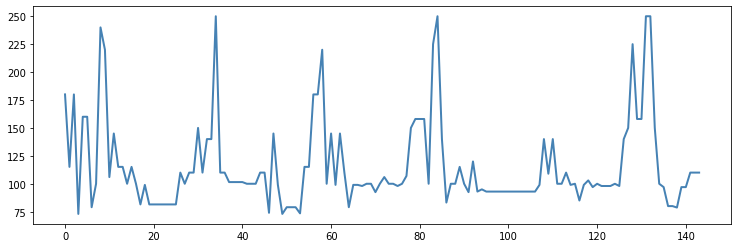

In [25]:
w_plot = 144 # 3 days
fontsize = 13

#y_pred = y_pred.reshape(len(y_pred))

#Residual = list(y_test) - y_pred

plt.figure(figsize=(12.5,4))
plt.plot(np.arange(0, 144), y_test[-226:-82], label = 'Real values', linewidth = 2, color = 'steelblue')
plt.plot(np.arange(0, 144), y_pred[-226:-82], label = 'Predicted values', linewidth = 1.8, color= 'deepskyblue')
#plt.plot(np.arange(0, 144), Residual[-226:-82], label = 'Residual error', linewidth = 1, color = 'slategrey')
plt.fill_between(np.arange(0, 144),  data['spike_lowerlim'][-226:-82], data['spike_upperlim'][-226:-82], facecolor='skyblue', alpha=0.5, label = 'Spike delimitator')
plt.ylim(-100, 260)
plt.xlim(0, 144 - 1)
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.xlabel('Accumulated SP', fontsize = fontsize)
plt.ylabel('RMSE (£/MWh)', fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks([-100, -50, 0, 50,100, 150, 200, 250],[-100, -50, 0, 50, 100, 150, 200, 250],  fontsize = fontsize)
plt.title('LSTM predictions', fontsize = fontsize + 2)
plt.legend(loc = 'lower right', fontsize = fontsize - 2)
plt.tight_layout()

In [26]:
y_pred

,all_param,Predicitons
0,{'bias_initializer': <tensorflow.python.ops.in...,"[[115.80347], [130.11774], [109.788895], [106...."
1,{'bias_initializer': <tensorflow.python.ops.in...,"[[115.00474], [134.26479], [112.73726], [106.8..."
2,{'bias_initializer': <tensorflow.python.ops.in...,"[[117.79856], [127.007164], [109.93257], [107...."
3,{'bias_initializer': <tensorflow.python.ops.in...,"[[91.58166], [91.58166], [91.58166], [91.58166..."
4,{'bias_initializer': <tensorflow.python.ops.in...,"[[117.8779], [117.8779], [117.8779], [117.8779..."
5,{'bias_initializer': <tensorflow.python.ops.in...,"[[111.802284], [111.802284], [111.802284], [11..."
